# Example Inference Processing (M100 Fluke)
> Summary description here.

In [7]:
#hide
from cellsegment.core import *
from nbdev.showdoc import *

## Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from  cellsegment.dataprep_utils import *
from cellsegment.set_directories import *
import pandas
from fastai.vision import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Define directories

In [21]:
dirs = Dirs('../testdata_2/')
print(dirs)

None
  basepath        :  ../testdata_2/       
  crop            :  ../testdata_2//Crop-200 
  cropLabel       :  ../testdata_2//Crop-200/Label 
  cropTest        :  ../testdata_2//Crop-200/Test 
  cropTrain       :  ../testdata_2//Crop-200/Train 
  cropValidTxtFile:  ../testdata_2//Crop-200/valid.txt 
  label           :  ../testdata_2//Fullsize/Label 
  model           :  ../testdata_2//models/ 
  originImages    :  ../testdata_2//Original 
  sizeCsvFile     :  ../testdata_2//file_size.csv 
  test            :  ../testdata_2//Fullsize/Test 
  train           :  ../testdata_2//Fullsize/Train 
  validTxtFile    :  ../testdata_2//Fullsize/valid.txt 



> Change this ....
> Dataset consists of legacy images and micro-i images
> Structure  
> Split into 70% Train, 15% Val, 15% Test  :  taken randomly for the 354 images.  
    - Original (jpg+csv+json)  [354 jpg; 354 csv; 354 json; Total = 1062]  
    - Fullsize    (random split into 70% Train, 15% Val, 15% Test)  
        - Train
            - (354 jpg + 354 json)
        - Label
            - (354 png)
    - Crop-200
        - Error
            - nil
        - Train
            - (443 jpg)
        - Labels
            - (526 png)
        - Test
            - (83 jpg)
        - valid.txt 
            - 73 file names

## get stats on images

In [24]:
MicroI_100_Images_path = dirs.originImages

print(MicroI_100_Images_path)

image_files = get_image_files(MicroI_100_Images_path)
json_files = get_files(MicroI_100_Images_path, extensions=['.json'])

for i, fn in enumerate(image_files):
    image_files[i] = fn.name.split('.')[0]
for i, fn in enumerate(json_files):
    json_files[i] = fn.name.split('.')[0]
    
print(f'Number of Micro-I images = {len(image_files)}')

print(f"Number of Micro-I json files = { len(json_files) }")
set1 = set(image_files)
set2 = set(json_files)

missing = list(sorted(set1 - set2))
added = list(sorted(set2 - set1))
print('missing:', len(missing), missing)
print('added:', len(added), added)




../testdata_2//Original
Number of Micro-I images = 30
Number of Micro-I json files = 30
missing: 0 []
added: 0 []


In [25]:
print("Show original image sizes")

height = 800
fnames = sorted(get_image_files(dirs.originImages))

list_filedata = [None] * len(fnames)
for i,fn in enumerate(fnames):
    img = PIL.Image.open(fn)
    img_w, img_h = img.size
    scale = float(height) / img_h
    list_filedata[i] = {'Name':fn.name, 'Width':img_w, 'Height':img_h, 'Scale':scale}

df = pd.DataFrame(list_filedata)
df = df[['Name', 'Width', 'Height']]
# print(df)

savefn = Path(dirs.sizeCsvFile)
if not savefn.exists():
    print(f'Saving {savefn}')
    df.to_csv(savefn)
else:
    print(f'Filename {savefn} already exists')
    
df.tail(10)


Show original image sizes
Saving ../testdata_2/file_size.csv


,Name,Width,Height
20,236569 - 14.jpg,796,791
21,236569 - 15.jpg,764,742
22,236569 - 21.jpg,794,792
23,236569 - 3.jpg,785,736
24,236569 - 4.jpg,767,740
25,236569 - 5.jpg,766,740
26,236569 - 6.jpg,762,740
27,236569 - 7.jpg,811,811
28,236569 - 8.jpg,868,795
29,236569 - 9.jpg,755,739


## Optional - Convert directory of CSV files to JSON files

In [23]:
# ds2.csv_to_json_dir(dirs.originImages, dirs.originImages, number_files='all')
       

## Resize jpg, json and png files to 800 x 800 

In [26]:
resize_dir(dirs.sizeCsvFile, dirs.originImages, dirs.train, number_files='all', height=800)

Number of image files: 30, Number to resize: all
::::::::::::::::::::::::::::::

In [27]:
resize_json_dir(dirs.sizeCsvFile, dirs.originImages, dirs.train, number_files='all', height=800)

Number of JSON files: 30, Number to resize: all
::::::::::::::::::::::::::::::
30  json files processed


30

In [28]:
print("Create label png images based on Json files and store in dest directory")
create_labels_dir(dirs.train, dirs.label, number_files='all')

Create label png images based on Json files and store in dest directory
Number of json files to process 30
::::::::::::::::::::::::::::::Number of labels files created 30


## Split into Train, Val and Test

In [29]:
file_csv = dirs.basepath+'/file_data.csv'
fnames = sorted(get_image_files(dirs.train))
fnames = [fn.name for fn in fnames]
df = pandas.DataFrame(fnames)
df.columns = ['Name']
df.to_csv(file_csv, index=True)

shuffle_csv(file_csv,random_state=23)

In [30]:
print('\n Split into train valid and test directories')
split_filenames(file_csv, num_train=0.5, num_val=0.25)


 Split into train valid and test directories


In [31]:
misslist, croplist= crop_img_dir(file_csv, dirs.train, dirs.train, dirs.crop, 
                                              number_files='all', DEBUG=False)
print(f'Num Missed: {len(misslist)}, Num Cropped: {len(croplist)}')

30 files to process in ../testdata_2/Fullsize/Train
::::::::::::::::::::::::::::::
Missed 0 and  Cropped 46 files in ../testdata_2/Crop-200
Num Missed: 0, Num Cropped: 46


In [32]:
crop_df = pd.DataFrame(croplist)
crop_df = crop_df[['Name','Label', 'Op']]
crop_df.to_csv(dirs.crop+'/crop_df.csv')
crop_df

,Name,Label,Op
0,236569 - 10-0.jpg,40,Train
1,236569 - 14-0.jpg,40,Train
2,236569 - 14-1.jpg,40,Train
3,236568 - 5-0.jpg,11,Train
4,236568 - 5-1.jpg,11,Train
5,236569 - 1-0.jpg,40,Train
6,236569 - 15-0.jpg,40,Train
7,236568 - 13-0.jpg,11,Train
8,236569 - 4-0.jpg,40,Train
9,236568 - 10-0.jpg,11,Train


In [33]:
valid_df = crop_df[crop_df.Op=='Valid'].loc[:,'Name']
valid_df.to_csv(dirs.crop+'/valid.txt', index=False)
valid_df.head(10)

/home/john/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


21     236568 - 6-0.jpg
22     236568 - 6-1.jpg
23     236568 - 6-2.jpg
24    236568 - 11-0.jpg
25    236568 - 11-1.jpg
26     236569 - 5-0.jpg
27     236569 - 3-0.jpg
28     236569 - 3-1.jpg
29     236569 - 8-0.jpg
30     236569 - 9-0.jpg
Name: Name, dtype: object

In [34]:
labmisslist, labcroplist = crop_img_dir(file_csv, dirs.train, dirs.label, dirs.crop, number_files='all')
print(f'Num Missed: {len(labmisslist)}, Num Cropped: {len(labcroplist)}')

30 files to process in ../testdata_2/Fullsize/Label
::::::::::::::::::::::::::::::
Missed 0 and  Cropped 46 files in ../testdata_2/Crop-200
Num Missed: 0, Num Cropped: 46


## test_data.csv

In [35]:
crop_df = pandas.read_csv(dirs.crop+'/crop_df.csv', index_col=0)
crop_df.loc[crop_df.Label == 40,'Label'] = 'Fluke-Rumen'
crop_df.loc[crop_df.Label == 11,'Label'] = 'Fluke-Liver'
crop_df.to_csv(dirs.crop+'/crop_df.csv')
crop_df.tail()

,Name,Label,Op
41,236568 - 3-1.jpg,Fluke-Liver,Test
42,236568 - 15-0.jpg,Fluke-Liver,Test
43,236568 - 15-1.jpg,Fluke-Liver,Test
44,236568 - 15-2.jpg,Fluke-Liver,Test
45,236569 - 13-0.jpg,Fluke-Rumen,Test


In [37]:
test_df = crop_df[crop_df.Op == 'Test'] 
test_df.to_csv(dirs.crop+'/test_df.csv', index=False)
test_df

,Name,Label,Op
33,236568 - 7-0.jpg,Fluke-Liver,Test
34,236568 - 8-0.jpg,Fluke-Liver,Test
35,236569 - 7-0.jpg,Fluke-Rumen,Test
36,236569 - 21-0.jpg,Fluke-Rumen,Test
37,236569 - 21-1.jpg,Fluke-Rumen,Test
38,236568 - 4-0.jpg,Fluke-Liver,Test
39,236568 - 4-1.jpg,Fluke-Liver,Test
40,236568 - 3-0.jpg,Fluke-Liver,Test
41,236568 - 3-1.jpg,Fluke-Liver,Test
42,236568 - 15-0.jpg,Fluke-Liver,Test


In [39]:
test_df.shape

(13, 3)

## Save label files without color pallet info
> otherwise databuch segmentation does not work

In [38]:
fnames =  get_image_files(Path(dirs.crop)/'Label')
# fnames = fnames[:3]
for fn in fnames:
    img = np.asarray(PIL.Image.open(fn))
    PIL.Image.fromarray(img.astype(np.uint8)).save(fn, quality=90)



## Test Create DataBunch

In [40]:
# create data set
from fastai.vision import *
from fastai.utils.mem import *
path_img = dirs.cropTrain
path_lbl = dirs.cropLabel

codes = np.array(['background', '1', '2', '3']);codes

get_label_fn = lambda x: f'{path_lbl}/{x.stem}.png'

src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_label_fn, classes=codes, convert_mode='RGB'))

tfms = get_transforms(flip_vert=True, max_rotate=None, max_zoom=1., max_warp=None)

bs = 8
data = (src.transform(tfms, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

## Show example images

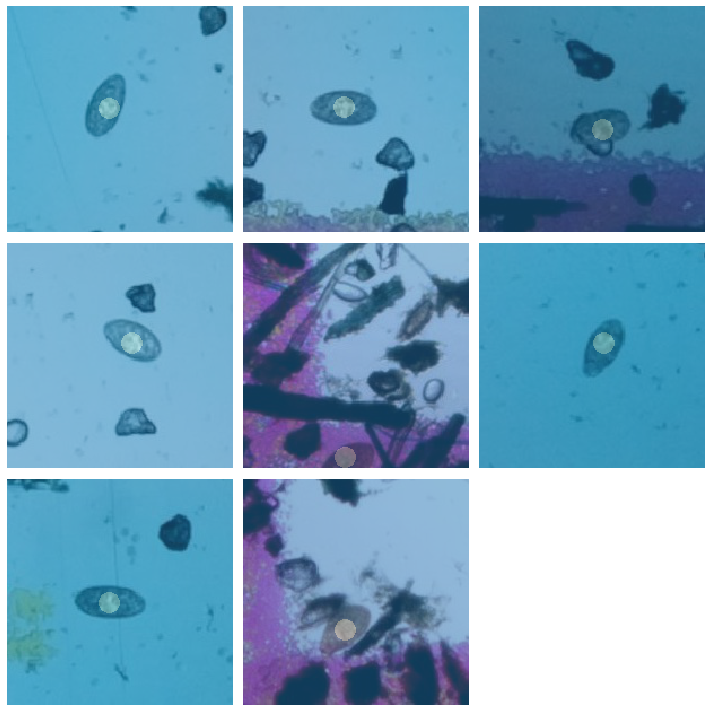

In [41]:
data.show_batch(4, ds_type=DatasetType.Train, figsize=(10,10))

In [41]:
def acc_metric1(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def acc_metric2(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)[target>0]==target[target>0]).float().mean()
  
metrics=[acc_metric1, acc_metric2]

wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()



## run fastai learn

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


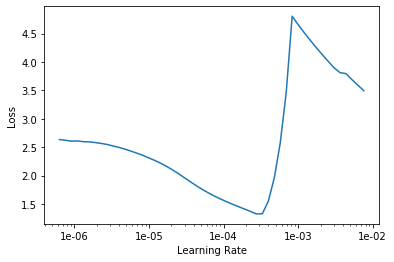

In [42]:
if torch.cuda.is_available():
    learn.lr_find()
    learn.recorder.plot()
